# 次元削減とクラスタリング


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.width', 1000)

In [2]:
# データ読み込み
df = pd.read_table('./input/count_tpm.tsv', index_col=0)
print(df.head())
print(len(df))

           batch_1  batch_2  batch_3  chemostat_1  chemostat_2  chemostat_3
gene_id                                                                    
gene_0001     0.47     1.05     0.98         0.00         0.00         0.20
gene_0002     0.00     0.00     0.00         0.00         0.00         0.00
gene_0003     0.00     0.00     0.00         0.00         0.00         0.00
gene_0004     0.00     0.33     0.00         0.00         0.00         0.00
gene_0005     1.78     2.68     4.22         5.88         1.48         2.93
5983


In [3]:
# 全サンプルでTPMがゼロの遺伝子のレコードを削除
all_zero_index = df.index[df.sum(axis=1) == 0]
df = df.drop(all_zero_index)
print(df.head())
print(len(df))

           batch_1  batch_2  batch_3  chemostat_1  chemostat_2  chemostat_3
gene_id                                                                    
gene_0001     0.47     1.05     0.98         0.00         0.00         0.20
gene_0004     0.00     0.33     0.00         0.00         0.00         0.00
gene_0005     1.78     2.68     4.22         5.88         1.48         2.93
gene_0009     1.24     1.16     1.31         3.04        14.34        15.43
gene_0010     8.28     7.88     8.32       157.41       236.04       224.30
5892


In [34]:
# サンプルをプロットするときの色を設定
sample_colors = {'batch_1':'b',  # b : blue
                 'batch_2':'b',
                 'batch_3':'b',
                 'chemostat_1':'g', # g: green
                 'chemostat_2':'g',
                 'chemostat_3':'g'}
colors = df.columns.map(sample_colors)

# PCA (Principal Component Analysis; 主成分分析)

In [5]:
import sklearn.decomposition

In [6]:
# PCA実行
pca = sklearn.decomposition.PCA()
coords = pca.fit_transform(df.transpose().values)

In [7]:
def scatter_plot(coords, sample_labels, colors):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(coords[:, 0], coords[:, 1], color=colors)
    for i, sample_label in enumerate(sample_labels):
        ax.annotate(sample_label, xy=(coords[i, :2]), xytext=(10,10),
                    textcoords='offset points', color=colors[i],
                   arrowprops={'arrowstyle':'-', 'edgecolor':colors[i]})
    plt.show()

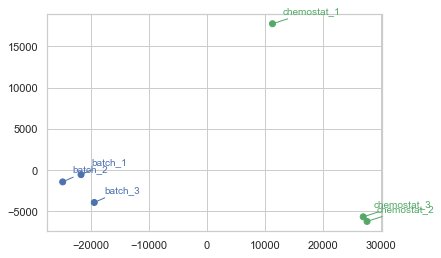

In [8]:
scatter_plot(coords, df.columns, colors)

In [9]:
# z-score 正規化
import sklearn.preprocessing
values = df.values
scaler = sklearn.preprocessing.StandardScaler()
std_values = scaler.fit_transform(values)
std_df = pd.DataFrame(std_values, index=df.index, columns=df.columns)

print('\nRaw values')
print('Average :')
print(df.mean(axis=0))
print('Standard deviation:')
print(df.std(axis=0))
print('\nStandardized values')
print('Average :')
print(std_df.mean(axis=0))
print('Standard deviation:')
print(std_df.std(axis=0))

# おんなじことを自分で計算する場合
# std_values = (df.values - df.values.mean(axis=0)) / df.values.std(axis=0)
# std_df2 = pd.DataFrame(std_values, index=df.index, columns=df.columns)
# print('\nStandardized values 2')
# print('Average :')
# print(std_df2.mean(axis=0))
# print('Standard deviation:')
# print(std_df2.std(axis=0))


Raw values
Average :
batch_1       169.72
batch_2       169.72
batch_3       169.72
chemostat_1   169.72
chemostat_2   169.72
chemostat_3   169.72
dtype: float64
Standard deviation:
batch_1       684.00
batch_2       725.70
batch_3       668.11
chemostat_1   523.17
chemostat_2   463.07
chemostat_3   456.27
dtype: float64

Standardized values
Average :
batch_1        0.00
batch_2       -0.00
batch_3       -0.00
chemostat_1    0.00
chemostat_2   -0.00
chemostat_3    0.00
dtype: float64
Standard deviation:
batch_1       1.00
batch_2       1.00
batch_3       1.00
chemostat_1   1.00
chemostat_2   1.00
chemostat_3   1.00
dtype: float64


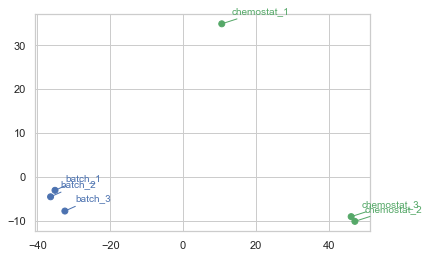

In [10]:
# 標準化されたデータでPCA実行
pca = sklearn.decomposition.PCA()
coords = pca.fit_transform(std_df.transpose().values)
scatter_plot(coords, std_df.columns, colors)

In [11]:
# 各主成分の「寄与率」
print(['{:.2f}%'.format(x*100) for x in pca.explained_variance_ratio_])

['83.60%', '15.44%', '0.72%', '0.15%', '0.09%', '0.00%']


# MDS (Multidimensional scaling; 多次元尺度構成法)

## metric MDS = PCoA (Principal Coordinate Analysis; 主座標分析)
構成する「距離行列」が、距離関数の要件を満たしている場合に適用可能な手法。
Bray-Curtis dissimilarityなど、三角不等式の要件を満たさない非類似性指標があるので注意。こういう場合はPCoAではなくnMDSを使う。
（しかしデータによっては偶然「計算できてしまう」ためにBray-Curtis dissimilarityでPCoAをやっている論文も...）

In [12]:
import sklearn.manifold

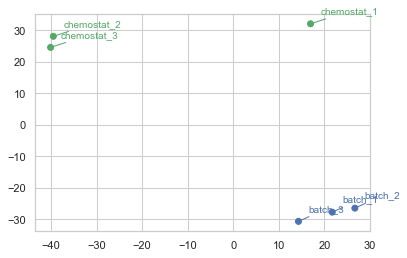

In [13]:
# デフォルトではユークリッド距離でサンプル間距離行列を計算。この場合、数学的には主成分分析と等価。
# ただしscikit-learnのMDS実装はiterativeに最適化するアルゴリズムになっているため（classical MDSは固有値分解に基づく手法）、
# ランダムな初期値の影響で実行のたびに結果が若干変わる
mds = sklearn.manifold.MDS(n_components=2, dissimilarity='euclidean')
coords = mds.fit_transform(std_df.transpose().values)
scatter_plot(coords, std_df.columns, colors)

In [14]:
# 距離行列の計算
from scipy.spatial.distance import pdist, squareform
distance_matrix = squareform(pdist(std_df.transpose().values))
print(distance_matrix)

#自分で距離行列を作る場合（上の一行とおんなじ計算結果）
# from scipy.spatial.distance import euclidean
# values = std_df.transpose().values
# distance_matrix_2 = []
# for i in range(values.shape[0]):
#     vec = []
#     for j in range(values.shape[0]):
#         vec.append(euclidean(values[i, :], values[j, :]))
#     distance_matrix_2.append(vec)
# print(np.array(distance_matrix_2))

[[ 0.          7.28339392  9.69107705 59.61010899 82.77231685 81.67822634]
 [ 7.28339392  0.         12.78566821 61.70292581 83.98067436 82.95451012]
 [ 9.69107705 12.78566821  0.         60.95272024 80.04381455 78.9356052 ]
 [59.61010899 61.70292581 60.95272024  0.         58.07482836 56.58996149]
 [82.77231685 83.98067436 80.04381455 58.07482836  0.          4.47298822]
 [81.67822634 82.95451012 78.9356052  56.58996149  4.47298822  0.        ]]


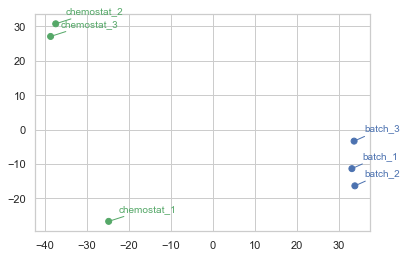

In [15]:
mds = sklearn.manifold.MDS(n_components=2, dissimilarity='precomputed')
coords = mds.fit_transform(distance_matrix)
scatter_plot(coords, std_df.columns, colors)

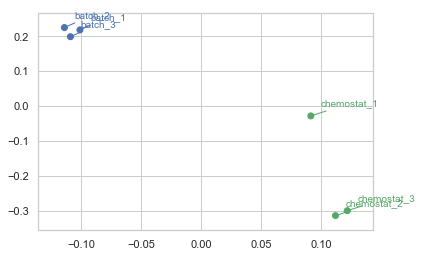

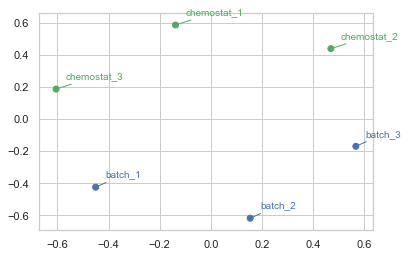

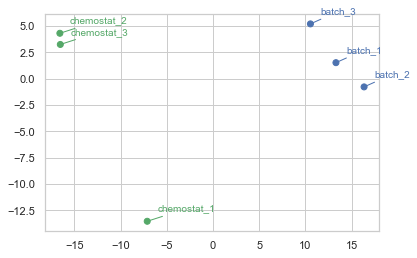

In [16]:
# 相関係数で計算した距離（1 - 相関係数）
distance_matrix = squareform(pdist(std_df.transpose().values, 'correlation'))
mds = sklearn.manifold.MDS(n_components=2, dissimilarity='precomputed')
coords = mds.fit_transform(distance_matrix)
scatter_plot(coords, std_df.columns, colors)
# Jaccard距離
distance_matrix = squareform(pdist(std_df.transpose().values, 'jaccard'))
mds = sklearn.manifold.MDS(n_components=2, dissimilarity='precomputed')
coords = mds.fit_transform(distance_matrix)
scatter_plot(coords, std_df.columns, colors)
# チェビシェフ距離
distance_matrix = squareform(pdist(std_df.transpose().values, 'chebyshev'))
mds = sklearn.manifold.MDS(n_components=2, dissimilarity='precomputed')
coords = mds.fit_transform(distance_matrix)
scatter_plot(coords, std_df.columns, colors)

## non-metric MDS (非計量多次元尺度構成法)
構成する「距離行列」が、距離関数の要件を満たさない場合に適用する。

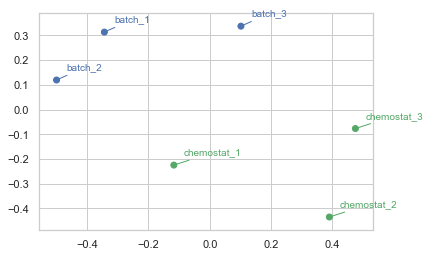

In [17]:
# Bray-Curtis 非類似度指標による計算
distance_matrix = squareform(pdist(std_df.transpose().values, 'braycurtis'))
nmds = sklearn.manifold.MDS(n_components=2, metric=False, dissimilarity='precomputed')
coords = nmds.fit_transform(distance_matrix)
scatter_plot(coords, std_df.columns, colors)

# 多様体学習

## Isomap

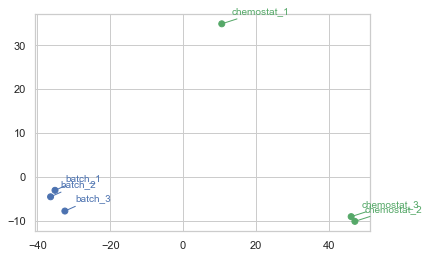

In [18]:
isomap = sklearn.manifold.Isomap(n_components=2)
coords = isomap.fit_transform(std_df.transpose().values)
scatter_plot(coords, std_df.columns, colors)

## LLE (Locally Linear Embedding)

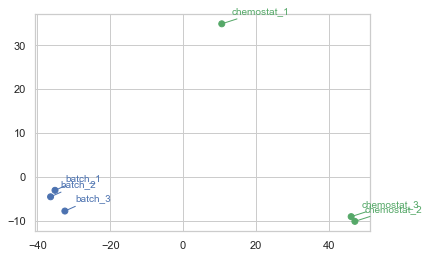

In [19]:
lle = sklearn.manifold.LocallyLinearEmbedding(n_components=2)
coords = isomap.fit_transform(std_df.transpose().values)
scatter_plot(coords, std_df.columns, colors)

## t-SNE (t-distributed Stochastic Neighbor Embedding)

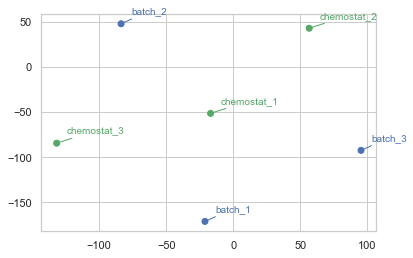

In [20]:
tsne = sklearn.manifold.TSNE(n_components=2)
coords = tsne.fit_transform(std_df.transpose().values)
scatter_plot(coords, std_df.columns, colors)

## UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction
[参考論文](https://arxiv.org/abs/1802.03426)
```bash
$conda install -c conda-forge umap-learn
```

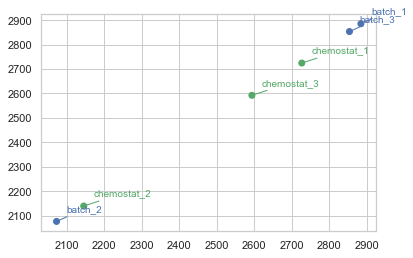

In [21]:
import umap
coords = umap.UMAP(n_components=2, n_neighbors=5, init='random').fit_transform(std_df.transpose().values)
scatter_plot(coords, std_df.columns, colors)

# クラスタリング

## 階層的クラスタリング

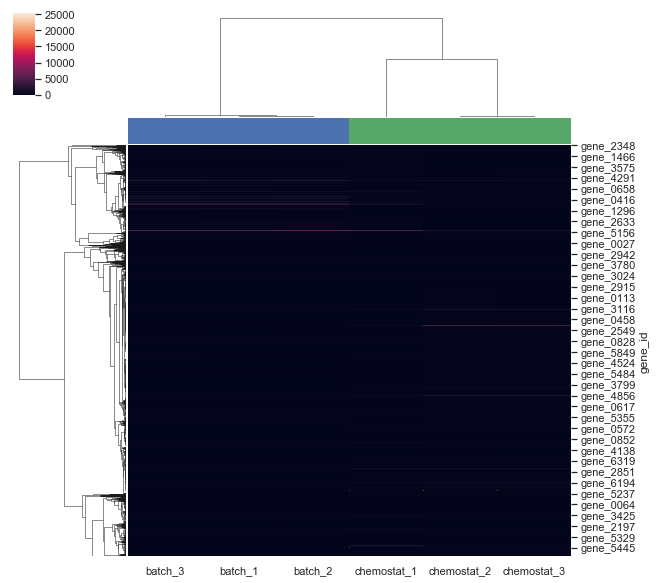

In [22]:
sns.clustermap(df, method='average', metric='correlation', col_colors=colors)

In [23]:
# 平均TPMがTop-10の遺伝子だけ抜き出し
top10_df = df.loc[ df.mean(axis=1).sort_values(ascending=False).index[:10]  , :]

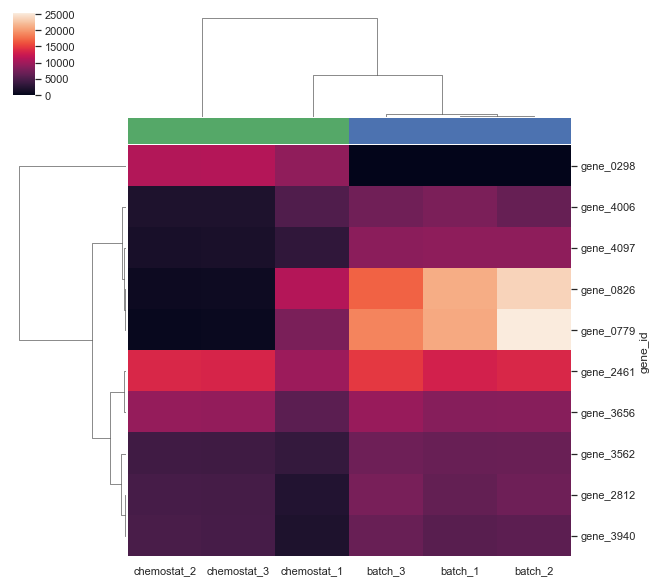

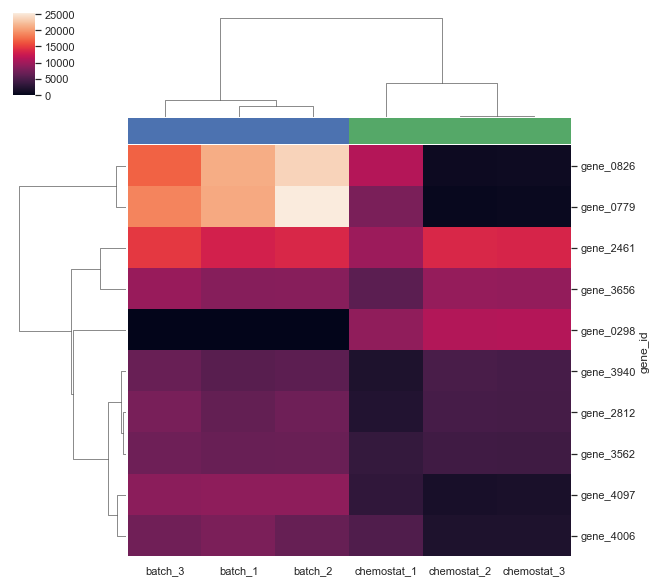

In [24]:
# サンプル間の距離計算手法、クラスター間の距離計算手法による違い
sns.clustermap(top10_df, method='average', metric='correlation', col_colors=colors)
sns.clustermap(top10_df, method='ward', metric='euclidean', col_colors=colors)

## K-means & K-medoids

### K-means clustering

In [25]:
import sklearn.cluster
model = sklearn.cluster.KMeans(n_clusters=2)
y = model.fit_predict(df.transpose().values)
print(y)

[1 1 1 0 0 0]


n_clusters: 2  Average silhouette score = 0.6919528244185106


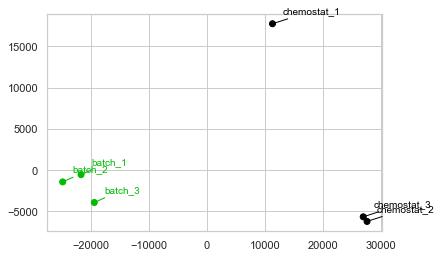

n_clusters: 3  Average silhouette score = 0.7113552872438685


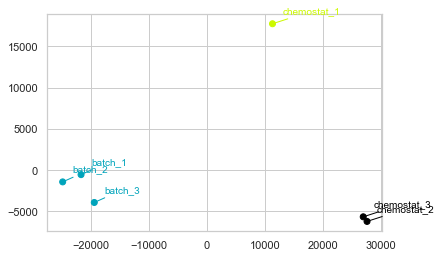

n_clusters: 4  Average silhouette score = 0.38921876908638375


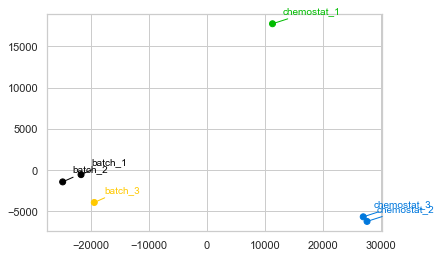

In [35]:
# silhouette解析による適切なクラスター数の推定
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm

X = df.transpose().values
pca = sklearn.decomposition.PCA()
pca_coords = pca.fit_transform(X)

for n_clusters in [2, 3, 4]:
    model = sklearn.cluster.KMeans(n_clusters=n_clusters)
    y = model.fit_predict(X)
    silhouette_avg = silhouette_score(X, y)
    print('n_clusters:',n_clusters,' Average silhouette score =',silhouette_avg)
    cluster_colors = cm.nipy_spectral(y.astype(float) / n_clusters)
    scatter_plot(pca_coords, std_df.columns, cluster_colors)

n_clusters: 2  Average silhouette score = 0.7049787496083262


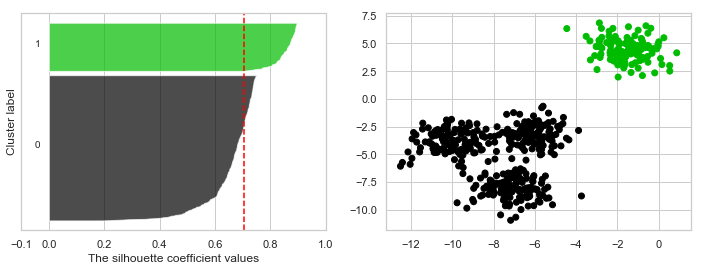

n_clusters: 3  Average silhouette score = 0.5882004012129721


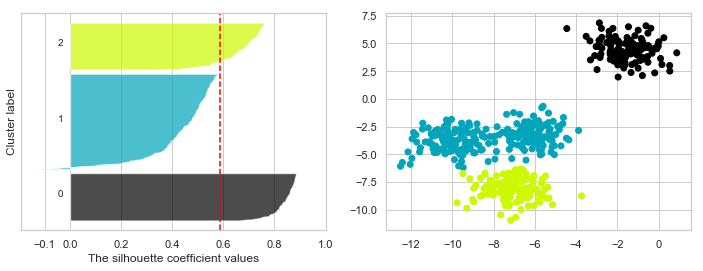

n_clusters: 4  Average silhouette score = 0.6505186632729437


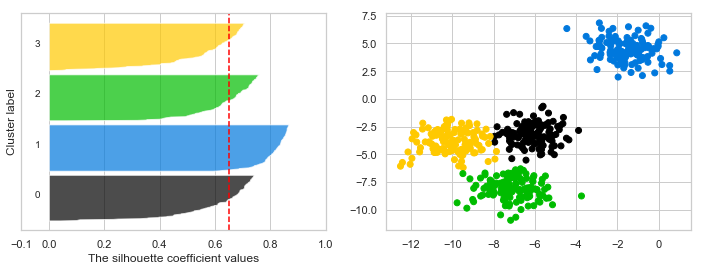

In [27]:
# もっとサンプル数がたくさんある場合は、サンプルごとのシルエットスコアの分布を比較できる
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

X, y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=1, center_box=(-10.0, 10.0), shuffle=True, random_state=1)

def plot_silhouette(n_clusters):
    fig = plt.figure(figsize=(12,4))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    model = sklearn.cluster.KMeans(n_clusters=n_clusters)
    cluster_labels = model.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print('n_clusters:',n_clusters,' Average silhouette score =',silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = np.sort(sample_silhouette_values[cluster_labels == i])
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cluster_colors = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=cluster_colors, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    cluster_colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], c=cluster_colors)
    plt.show()

for n_clusters in [2, 3, 4]:
    plot_silhouette(n_clusters)

### K-medoids clustering

平均（mean）ではなくmedoid（すべてのデータ点との距離の和が最小になるデータ点）を使う点だけがK-meansと異なる。

実データの平均を計算する必要がないため、実データを入力する必要がなく、距離行列があればいい => ユークリッド距離である必要はなく、任意の距離関数を使える。

In [28]:
# K-medoids clusteringをscikit-learnの使用感っぽく使えるように実装した。エラーハンドリングとか全然してないので注意。
# 参考：https://www.researchgate.net/publication/272351873_NumPy_SciPy_Recipes_for_Data_Science_k-Medoids_Clustering

import numpy as np
from scipy.spatial.distance import pdist, squareform

class KMedoids():
    """K-Medoids clustering
    
    Parameters
    ----------
    n_clusters : int, optional, default: 2
        Number of clusters to form.
    max_iter : int, optional, default: 100
        Maximum number of iterations of the k-medoids algorithm.
    verbose : boolean, optional, default: False
        Verbosity mode.
    random_state : int, RandomState instance or None, optional, default: None
    dissimilarity : 'euclidean' | 'precomputed', optional, default: 'euclidean'
        Dissimilarity measure to use:
            - 'euclidean':
                Pairwise Euclidean distances between points in the dataset.
            - 'precomputed':
                Pre-computed dissimilarities are passed.
    
    Attributes
    ----------
    cluster_medoids_ : array, [n_clusters]
        Indices of cluster medoids
    labels_ :
        Labels of each point
    """
    def __init__(self, n_clusters=2, max_iter=100, verbose=False,
                random_state=None, dissimilarity='euclidean'):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.verbose = verbose
        self.random_state = random_state
        self.dissimilarity = dissimilarity
    
    def _init_medoids(self, X, n_clusters, random_state):
        n_samples = X.shape[0]
        init_indices = random_state.choice(n_samples, n_clusters, replace=False)
        return np.sort(init_indices)
    
    def _k_medoids(self, X, n_clusters, max_iter, random_state, verbose):
        # 初期medoidsをランダムにn_clusters個選択。
        medoids = self._init_medoids(X, n_clusters, random_state)
        if self.verbose:
            print('initial medoids =', medoids)
        new_medoids = np.copy(medoids)
        # ループ開始。medoidsが収束するまで繰り返す。
        for i in range(max_iter):
            # 各サンプルをもっとも近いmedoidsに割り当てる。
            assigned_cluster_labels = np.argmin(X[:, medoids], axis=1)
            for c in range(n_clusters): # クラスタごとに新たなmedoidsを選択。
                # クラスタc に割り当てられたサンプルのインデックスを取得。
                sample_indices_in_c = np.where(assigned_cluster_labels == c)[0]
                # クラスタc に割り当てられたサンプル内の距離行列を抽出。
                distance_matrix_of_c = X[np.ix_(sample_indices_in_c, sample_indices_in_c)]
                # クラスタc 内の各サンプルについて、同一クラスタ内サンプルとの平均距離を計算
                average_distance_in_c = np.mean(distance_matrix_of_c, axis=1)
                # 新たなmedoidは平均距離がもっとも小さいサンプル。
                new_medoid_index_in_c = np.argmin(average_distance_in_c)
                new_medoid_index = sample_indices_in_c[new_medoid_index_in_c]
                new_medoids[c] = new_medoid_index
            np.sort(new_medoids)
            if self.verbose:
                print('\titeration:',i,'\n\t\tnew medoids=',new_medoids)
            if np.array_equal(new_medoids, medoids):
                # medoidsのインデックスが更新されなかったらループ終了。
                break
            medoids = np.copy(new_medoids)
        assigned_cluster_labels = np.argmin(X[:, medoids], axis=1)
        return medoids, assigned_cluster_labels
    
    def fit(self, X):
        """Compute k-medoids clustering.
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            Input data. If ``dissimilarity == 'precomputed'``, the input should
            be the dissimilarity matrix.
        """
        if self.dissimilarity == 'precomputed':
            self.dissimilarity_matrix_ = X
        elif self.dissimilarity == 'euclidean':
            self.dissimilarity_matrix_ = squareform(pdist(X))
        else:
            raise ValueError("dissimilarity must be 'precomputed' or 'euclidean'.")
        if self.random_state is None or self.random_state is np.random:
            self.random_state = np.random.mtrand._rand
        elif isinstance(self.random_state, int):
            self.random_state = np.random.RandomState(self.random_state)
        elif isinstance(self.random_state, np.random.RandomState):
            self.random_state = np.random.RandomState
        else:
            raise ValueError("%r cannot be used to seed a numpy.random.RandomState" % self.random_state)
        self.cluster_medoids_, self.labels_ = \
            self._k_medoids(self.dissimilarity_matrix_, self.n_clusters, self.max_iter, self.random_state, self.verbose)
        return self
    
    def fit_predict(self, X):
        """Compute k-medoids clustering and predict cluster index for each sample.
        """
        return self.fit(X).labels_

In [30]:
# K-medoidsクラスタリングの実行
distance_matrix = squareform(pdist(df.transpose().values, metric='correlation')) # 相関係数距離行列
n_clusters = 2

model = KMedoids(n_clusters=n_clusters, dissimilarity='precomputed', verbose=True)
model.fit(distance_matrix)
medoids = model.cluster_medoids_
labels = model.labels_
print('\nMedoids :',df.columns[medoids].values)
print('Clusters :')
for cluster in range(n_clusters):
    print('\tcluster-',cluster,': ',df.columns[labels == cluster].values)

initial medoids = [4 5]
	iteration: 0 
		new medoids= [4 2]
	iteration: 1 
		new medoids= [5 0]
	iteration: 2 
		new medoids= [5 0]

Medoids : ['chemostat_3' 'batch_1']
Clusters :
	cluster- 0 :  ['chemostat_1' 'chemostat_2' 'chemostat_3']
	cluster- 1 :  ['batch_1' 'batch_2' 'batch_3']


## NMF (Non-negative Matrix Factorization; 非負値行列因子分解)

X ~ W * H


X: non-negative matrix. (n, m)

W: non-negative matrix. (n, k)

H: non-negative matrix. (k, m)

In [36]:
model = sklearn.decomposition.NMF(n_components=2)
W = model.fit_transform(df.values)
H = model.components_

print('Original shape=',df.values.shape)
print('W shape =',W.shape)
print('H shape =',H.shape)

Original shape= (5892, 6)
W shape = (5892, 2)
H shape = (2, 6)


[[177.52828588 188.17519289 169.82100783  62.56697448   4.36203027
    6.39263374]
 [  2.10760132   0.           9.94428817 107.32702137 150.56887151
  147.74777177]]


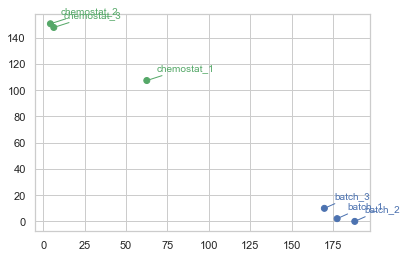

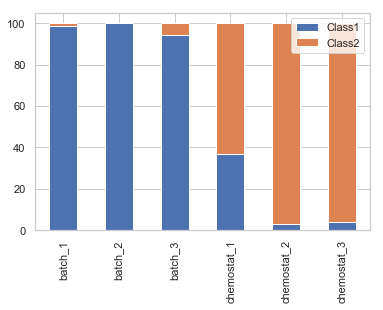

In [37]:
# 次元削減としての利用
print(H)
scatter_plot(H.T, df.columns, colors)
H_percentage = 100.0 * H / H.sum(axis=0)
pd.DataFrame(H_percentage.T, index=df.columns, columns=['Class1', 'Class2']).plot.bar(stacked=True)

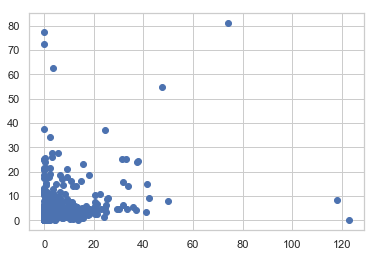

In [38]:
# それぞれの因子に強く寄与している遺伝子はなにか？
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(W[:,0], W[:,1])
plt.show()

In [39]:
# 遺伝子のproduct情報をロード
gene_products = pd.read_table('./input/gene_id_product.tsv', index_col=0, names=["gene_id", "product"])
df_with_prod = df.join(gene_products, how='left') # 左外部結合

In [40]:
# 因子１　に強く寄与する遺伝子
topN = 50
top_factor1 = df_with_prod.index[ np.argsort(W[:,0] - W[:,1])[::-1][:topN] ]
print(df_with_prod.loc[top_factor1, :])

            batch_1   batch_2   batch_3  chemostat_1  chemostat_2  chemostat_3                                            product
gene_id                                                                                                                          
gene_0779 21,119.49 25,422.79 18,890.42     7,902.06       606.03       685.00                 ribosomal 60S subunit protein L41A
gene_0826 21,258.89 23,819.77 17,080.42    11,303.53       829.71       998.97                 ribosomal 60S subunit protein L41B
gene_4097  9,061.91  9,095.55  8,899.22     3,262.47     1,664.11     1,736.73  ubiquitin-ribosomal 40S subunit protein S31 fu...
gene_3130  7,224.97  7,533.86  7,018.90     3,437.39       463.92       606.85                  ribosomal 60S subunit protein L39
gene_2599  6,559.13  6,699.86  6,872.47     2,366.08       886.31       979.24                  ribosomal 40S subunit protein S20
gene_1498  8,115.32  6,861.76  7,153.68     5,299.42       962.68     1,088.26            

In [41]:
# 因子2　に強く寄与する遺伝子
top_factor2 = df_with_prod.index[ np.argsort(W[:,0] - W[:,1])[:topN] ]
print(df_with_prod.loc[top_factor2, :])

           batch_1  batch_2  batch_3  chemostat_1  chemostat_2  chemostat_3                                            product
gene_id                                                                                                                       
gene_0298    45.04    35.77    30.20     9,196.32    11,172.02    11,295.66                            chaperone protein HSP26
gene_5880    87.45    39.87    35.63     6,637.19    11,573.66    10,885.76              aldehyde dehydrogenase (NADP(+)) ALD4
gene_1889   251.76    62.57    66.61    13,721.24     6,890.26     7,083.67                        lipid-binding protein HSP12
gene_3497     7.89     5.58     4.54     2,536.46     5,995.31     6,325.99                                              Jen1p
gene_1038   879.39   285.37   249.35     4,679.87     4,790.91     4,849.32                                              Sed1p
gene_0067   256.21   222.21   222.25     1,684.90     4,344.79     4,134.23                           Hsp70 fam